### 利用中心點座標位置進行分群

In [26]:
# import igl
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import pairwise_distances_argmin_min
# import skfuzzy as fuzz
# import meshplot as mp
# from sklearn.cluster import DBSCAN

# def cluster_with_center(stl_file_path,curve_range,n_label):
#     # 從指定檔案讀取三角網格數據
#     v, f = igl.read_triangle_mesh(stl_file_path)

#     # 初始化矩陣，每行表示一個面的中心點座標
#     face_centers = np.zeros((len(f), 3))

#     # 遍歷每個面，計算中心點座標為三個頂點座標的平均值
#     for i in range(len(f)):
#         face_vertices = v[f[i], :]
#         face_centers[i, :] = np.mean(face_vertices, axis=0)


#     # 使用 DBSCAN 算法進行分群
#     dbscan = DBSCAN(eps=0.1, min_samples=2)  # 根據需要調整參數
#     labels_db = dbscan.fit_predict(face_centers)
#     unique_labels = np.unique(labels_db)
#     num_clusters = len(unique_labels)


#     rebuild=[]
#     # 在右側的子圖中繪製分群後的三角網格
#     # ax1.set_title('Clustered Mesh')
#     for cluster_label in range(num_clusters):
#         cluster_indices = np.where(labels_db == cluster_label)[0]
#         if len(cluster_indices) > 0:
            
#             cluster_faces = f[cluster_indices]
#             # cluster_vertices = v[cluster_faces[0]]
#             igl.write_triangle_mesh(f'curvature{curve_range}_n{n_label}_center{cluster_label}.stl', v, cluster_faces)   ##這裡可能要修改，頂點應該只有 cluster_faces接觸的頂點才對
#             rebuild.append(f'curvature{curve_range}_n{n_label}_center{cluster_label}.stl')




#### 將沒有連接的區塊區分開來

In [27]:
import numpy as np
import igl
import os



def check_overlap(group1, group2):
    # print("g1=",group1)
    # print("g2=",group2)
    for row1 in group1:
        for row2 in group2:
            if np.any(row1 == row2):
                return True
    return False

def merge_groups(groups):
    merged = True
    while merged:
        merged = False
        for i in range(len(groups)):
            for j in range(i + 1, len(groups)):
                if check_overlap(groups[i], groups[j]):
                    groups[i] += groups[j]
                    del groups[j]
                    merged = True
                    break
            if merged:
                break
    return groups

def create_groups(matrix):#如果matrix只有一個row(Ex. np.array([1,2,3])),check_overlap將不可迭帶

    if not isinstance(matrix, np.ndarray) or matrix.ndim != 2:
        matrix = np.atleast_2d(matrix)

    groups = []
    for row in matrix:
        found_group = False
        for group in groups:
            if check_overlap(group, [row]):
                group.append(row)
                found_group = True
                break
        if not found_group:
            added_to_existing_group = False
            for group in groups:
                if any(check_overlap([row], existing_row) for existing_row in group):
                    group.append(row)
                    added_to_existing_group = True
                    break
            if not added_to_existing_group:
                groups.append([row])
    return groups

test=np.array([[1,2,3],[2,2,2]])
create_groups(test)

def group_connect (stl_file_path,curve_range,cluster_label):
    v, f = igl.read_triangle_mesh(stl_file_path)
    groups = create_groups(f)
    merged_groups = merge_groups(groups)

    # 將每個群組存為獨立的.obj檔案
    for idx, group in enumerate(merged_groups):
        if group:
            # 創建新的頂點和面數組以儲存當前群組
            group_faces = np.vstack(group)
            group_vertices = np.unique(group_faces.flatten())
            group_v = v[group_vertices]
            group_f = []
            for face in group_faces:
                group_f.append([np.where(group_vertices == vertex)[0][0] for vertex in face])
            group_f = np.array(group_f)

            # 將群組存為.obj檔案
            # igl.write_triangle_mesh(f'curvature{curve_range}_n{cluster_label}_g{idx + 1}.obj', group_v, group_f)
            output_path = os.path.join(r"C:\alan\ITRI\Robot_Arm\output_obj",f'curvature{curve_range}_n{cluster_label}_g{idx + 1}.obj' )
            igl.write_triangle_mesh(output_path, group_v, group_f)


### 利用法向量進行分群

In [28]:
import igl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances_argmin_min
import skfuzzy as fuzz
import meshplot as mp
from sklearn.cluster import DBSCAN


def cluster_with_normal(stl_file_path,curve_range):
    # 從指定檔案讀取三角網格數據
    v, f = igl.read_triangle_mesh(stl_file_path)


    # 計算每個面的法向量
    face_normals = np.cross(v[f[:, 1]] - v[f[:, 0]], v[f[:, 2]] - v[f[:, 0]])

    # 將法向量歸一化
    f_normals= face_normals / np.linalg.norm(face_normals, axis=1)[:, np.newaxis]

    # 初始化矩陣，每行表示一個面的中心點座標
    face_centers = np.zeros((len(f), 3))

    # # 遍歷每個面，計算中心點座標為三個頂點座標的平均值
    # for i in range(len(f)):
    #     face_vertices = v[f[i], :]
    #     face_centers[i, :] = np.mean(face_vertices, axis=0)


    # 使用 DBSCAN 算法進行分群
    dbscan = DBSCAN(eps=0.25, min_samples=1)  # 根據需要調整參數
    labels_db = dbscan.fit_predict(f_normals)
    unique_labels = np.unique(labels_db)
    num_clusters = len(unique_labels)


    
    # 在右側的子圖中繪製分群後的三角網格
    # ax1.set_title('Clustered Mesh')
    for cluster_label in range(num_clusters):
        cluster_indices = np.where(labels_db == cluster_label)[0]
        if len(cluster_indices) > 0:
            
            cluster_faces = f[cluster_indices]
            # cluster_vertices = v[cluster_faces[0]]
            output_path = os.path.join(r"C:\alan\ITRI\Robot_Arm\cluster_n",f'curvature{curve_range}_n{cluster_label}.obj' )
            igl.write_triangle_mesh(output_path, v, cluster_faces)   ##這裡可能要修改，頂點應該只有 cluster_faces接觸的頂點才對
            
            group_connect(output_path,curve_range,cluster_label)
            print(f'curve{curve_range}_n{cluster_label}.obj')


### 利用曲率進行分群

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def classify_with_curvature(stl_file_path):
    # 從指定檔案讀取三角網格數據
    v, f = igl.read_triangle_mesh(stl_file_path)
    v1, v2, k1, k2 = igl.principal_curvature(v, f)
    h=(k1+k2)/2#平均曲率

    # 計算每個面的曲率(取三頂點中曲率絕對值最大值最為face的曲率)
    face_curvatures = []
    # 對於每個面的索引 face in f
    for face in f:
        # 取出三個頂點的曲率值
        curvatures = [h[face[0]], h[face[1]], h[face[2]]]
        # 找到絕對值最大的曲率值
        max_curvature = max(curvatures, key=abs)
        # 將最大曲率值加入到列表中
        face_curvatures.append(max_curvature)

    # 將 face_curvatures 轉換為 NumPy 陣列
    face_curvatures = np.array(face_curvatures)
    # 將法向量歸一化
    norm_x = np.linalg.norm(face_curvatures)
    face_curvatures = face_curvatures/ norm_x

    def plot_bar_chart(data):
        plt.bar(range(len(data)), data)
        plt.show()
    curvature_distribute=np.sort(face_curvatures)
    plot_bar_chart(curvature_distribute)

    
    curve_range=" 0.02"
    selected_vertices = np.where(face_curvatures>=0.02)[0]
    if len(selected_vertices)!=0:
        cluster_faces = f[selected_vertices]
        output_path = os.path.join(r"C:\alan\ITRI\Robot_Arm\classify_curvature",'curv 0.02.obj' )
        igl.write_triangle_mesh(output_path, v, cluster_faces) 
        cluster_with_normal(output_path ,curve_range)
    
    curve_range=" -0.02_0.02"
    selected_vertices = np.where((face_curvatures<0.02) & (face_curvatures>-0.02))[0]
    if len(selected_vertices)!=0:
        cluster_faces = f[selected_vertices]
        output_path = os.path.join(r"C:\alan\ITRI\Robot_Arm\classify_curvature",'curv-0.02_0.02.obj' )
        igl.write_triangle_mesh(output_path, v, cluster_faces) 
        cluster_with_normal(output_path ,curve_range)
    
    curve_range=" -0.02"
    selected_vertices = np.where(face_curvatures<=-0.02)[0]
    if len(selected_vertices)!=0:
        cluster_faces = f[selected_vertices]
        output_path = os.path.join(r"C:\alan\ITRI\Robot_Arm\classify_curvature",'curv-0.02.obj' )
        igl.write_triangle_mesh(output_path, v, cluster_faces) 
        cluster_with_normal(output_path ,curve_range)





#### 讀取模型檔案

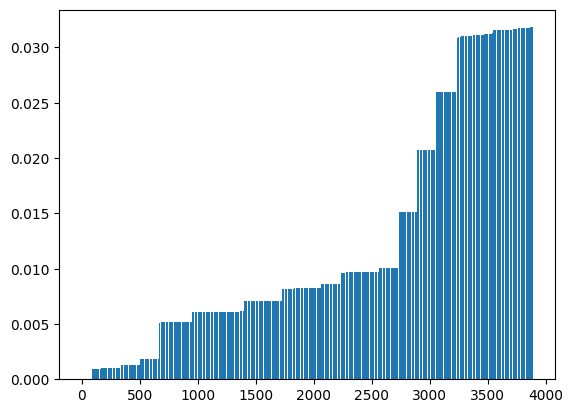

curve 0.02_n0.obj
curve 0.02_n1.obj
curve -0.02_0.02_n0.obj
curve -0.02_0.02_n1.obj
curve -0.02_0.02_n2.obj


In [30]:
import os
import igl

imput_path=r"C:\alan\ITRI\Robot_Arm\input_obj\555.obj"
classify_with_curvature(imput_path)